# Kolmogorov–Arnold Networks vs MLP – Heart Disease Dataset (Demo)

This notebook provides a simplified demonstration of the experiments from my MSc thesis.  
It compares **Kolmogorov–Arnold Networks (KANs)** and **Multilayer Perceptrons (MLPs)**  
on the well-known **Heart Disease dataset**.

---


## 📂 Dataset & Preprocessing

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

In [2]:
# Caricamento e preparazione del dataset
df = pd.read_csv(r'C:\Users\Luca Ruocco\Desktop\Dataset Tesi Luca\1. HEART\heart.csv')
X = df.drop('target', axis=1).values
y = df['target'].values

## RICORDA DI FARE LE DESCRITTIVE DEL DATASET (Eventuale Pre-Processing)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#######################################################################################################################################################
#######################################################################################################################################################
#######################################################################################################################################################

## 🔹 MLP Implementation

In [5]:
import torch
import numpy as np
import random

# Imposta il seed per garantire la riproducibilità
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Se stai usando una GPU, puoi impostare anche questo:
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # se usi più GPU

# Assicurati che il determinismo sia attivo (potrebbe rallentare un po' l'esecuzione)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

##########################################################################################################################
# Definizione della classe MLP con possibilità di variare la funzione di attivazione
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(activation_fn())
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Funzione per addestrare e valutare il modello
def train_and_evaluate_model(hidden_sizes, activation_fn):
    model = MLP(input_size=X_train.shape[1], hidden_sizes=hidden_sizes, output_size=len(np.unique(y)), activation_fn=activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_accuracy = accuracy_score(y_test_tensor, test_predicted)
    
    return test_accuracy, model

# Strutture da testare
hidden_layer_structures = [
    [5], [6], [7], [8], [10], [12], [15], [18], [20], [25], [30],
    [5,5], 
    [6,5], [6,6],
    [7,5], [7,6], [7,7],
    [8,5], [8,6], [8,7], [8,8],
    [10,5], [10,6], [10,7], [10,8], [10,10],
    [12,5], [12,6], [12,7], [12,8], [12,10], [12,12],
    [15,5], [15,6], [15,7], [15,8], [15,10], [15,12], [15,15],
    [20,5], [20,6], [20,7], [20,8], [20,10], [20,12], [20,15], [20,20],
    [32],
    [64],
    [32, 16],
    [64, 32],
]

# Funzioni di attivazione da testare
activation_functions = [
    nn.ReLU,
    nn.Sigmoid,
    nn.Tanh,
    nn.LeakyReLU,
    nn.ELU,
    nn.SELU,
    nn.Softplus,
    nn.Softsign,
    nn.ReLU6,
    nn.GELU,
    nn.Hardtanh,
    nn.LogSigmoid,
    
]

# Testare diverse strutture e funzioni di attivazione
results = {}
selected_model = None
selected_config = None

for structure in hidden_layer_structures:
    for activation_fn in activation_functions:
        accuracy, model = train_and_evaluate_model(structure, activation_fn)
        config_name = f"Structure: {structure}, Activation: {activation_fn.__name__}"
        results[config_name] = accuracy
        print(f"{config_name} -> Test Accuracy = {accuracy:.4f}")
        
        # Salva il modello se soddisfa i criteri desiderati
        if structure == [8] and activation_fn == nn.ReLU6:
            selected_model = model  # Salva il modello corrente
            selected_config = config_name  # Salva il nome della configurazione

# Seleziona il modello che hai scelto e salvalo
if selected_model is not None:
    torch.save(selected_model.state_dict(), 'selected_model.pth')
    print(f"Modello selezionato salvato come 'selected_model.pth' con configurazione: {selected_config}")
else:
    print("Nessun modello corrisponde ai criteri specificati.")

# Caricamento del modello selezionato (opzionale)
# Crea un'istanza del modello con la stessa architettura
loaded_model = MLP(input_size=X_train.shape[1], hidden_sizes=[8], output_size=len(np.unique(y)), activation_fn=nn.ReLU)

# Carica i pesi salvati nel modello
loaded_model.load_state_dict(torch.load('selected_model.pth'))

# Ora `loaded_model` è pronto per l'uso


Structure: [5], Activation: ReLU -> Test Accuracy = 0.7017
Structure: [5], Activation: Sigmoid -> Test Accuracy = 0.4706
Structure: [5], Activation: Tanh -> Test Accuracy = 0.7017
Structure: [5], Activation: LeakyReLU -> Test Accuracy = 0.6639
Structure: [5], Activation: ELU -> Test Accuracy = 0.6933
Structure: [5], Activation: SELU -> Test Accuracy = 0.5756
Structure: [5], Activation: Softplus -> Test Accuracy = 0.7689
Structure: [5], Activation: Softsign -> Test Accuracy = 0.5462
Structure: [5], Activation: ReLU6 -> Test Accuracy = 0.7563
Structure: [5], Activation: GELU -> Test Accuracy = 0.7101
Structure: [5], Activation: Hardtanh -> Test Accuracy = 0.6765
Structure: [5], Activation: LogSigmoid -> Test Accuracy = 0.5252
Structure: [6], Activation: ReLU -> Test Accuracy = 0.5924
Structure: [6], Activation: Sigmoid -> Test Accuracy = 0.7311
Structure: [6], Activation: Tanh -> Test Accuracy = 0.7395
Structure: [6], Activation: LeakyReLU -> Test Accuracy = 0.8025
Structure: [6], Activa

<All keys matched successfully>

Accuracy: 0.8319
Precision: 0.8308
Recall (Sensitivity): 0.8571
F1-Score: 0.8438
ROC-AUC: 0.8882

Confusion Matrix:
[[ 90  22]
 [ 18 108]]


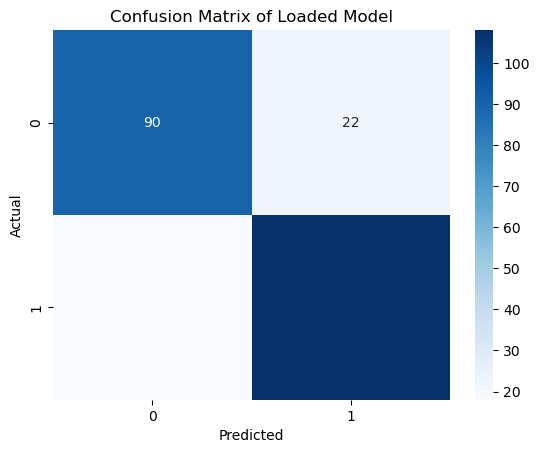


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82       112
           1       0.83      0.86      0.84       126

    accuracy                           0.83       238
   macro avg       0.83      0.83      0.83       238
weighted avg       0.83      0.83      0.83       238



In [7]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Imposta il seed per garantire la riproducibilità
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Se stai usando una GPU, puoi impostare anche questo:
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # se usi più GPU

# Assicurati che il determinismo sia attivo (potrebbe rallentare un po' l'esecuzione)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Definizione della classe MLP con possibilità di variare la funzione di attivazione
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(activation_fn())
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Carica il modello salvato
input_size = X_train.shape[1]
hidden_sizes = [8]  # La struttura scelta
output_size = len(np.unique(y))
activation_fn = nn.ReLU6  # La funzione di attivazione scelta

# Crea il modello
loaded_model = MLP(input_size, hidden_sizes, output_size, activation_fn)

# Carica lo stato del modello
loaded_model.load_state_dict(torch.load('selected_model.pth'))

# Valutazione del modello
loaded_model.eval()
with torch.no_grad():
    test_outputs = loaded_model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs.data, 1)

# Calcolo delle metriche
y_true = y_test_tensor.numpy()
y_pred = test_predicted.numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, test_outputs.numpy()[:, 1])

# Stampa delle metriche
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

# Matrice di confusione
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Matrice di confusione
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Loaded Model')
plt.show()

# Report di classificazione
print("\nClassification Report:\n", classification_report(y_true, y_pred))


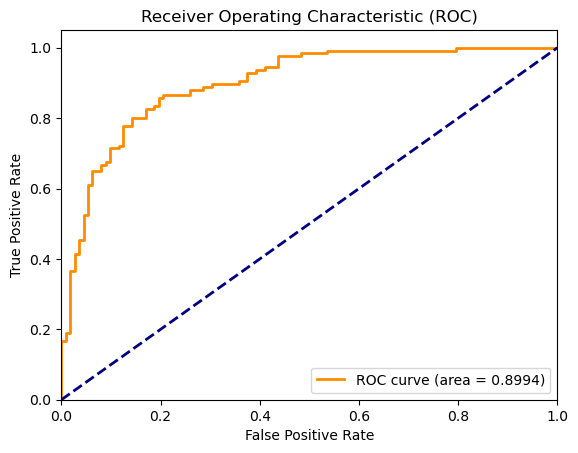

In [8]:
import torch
import numpy as np
import random
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Imposta il seed per garantire la riproducibilità
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Se stai usando una GPU, puoi impostare anche questo:
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # se usi più GPU

# Assicurati che il determinismo sia attivo (potrebbe rallentare un po' l'esecuzione)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Definizione della classe MLP con possibilità di variare la funzione di attivazione
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(activation_fn())
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Carica il modello salvato
input_size = X_train.shape[1]
hidden_sizes = [8]  # La struttura scelta
output_size = len(np.unique(y))
activation_fn = nn.ReLU6  # La funzione di attivazione scelta

# Crea il modello
loaded_model = MLP(input_size, hidden_sizes, output_size, activation_fn)

# Carica lo stato del modello
loaded_model.load_state_dict(torch.load('selected_model.pth'))

# Valutazione del modello
loaded_model.eval()
with torch.no_grad():
    test_outputs = loaded_model(X_test_tensor)
    probabilities = torch.softmax(test_outputs, dim=1)[:, 1].numpy()  # Probabilità per la classe positiva

# Calcolo delle metriche ROC
fpr, tpr, thresholds = roc_curve(y_test_tensor.numpy(), probabilities)
roc_auc = auc(fpr, tpr)

# Plot della ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [11]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Ottieni i nomi delle feature dal DataFrame originale
feature_names = list(df.columns)  # Assumendo che 'df' sia il tuo DataFrame originale

# Funzione per calcolare l'importanza delle feature tramite permutazione
def permutation_importance(model, X_test, y_test):
    baseline_accuracy = accuracy_score(y_test, model(X_test).argmax(dim=1).numpy())
    importances = []
    
    for col in range(X_test.shape[1]):
        # Permuta i valori della colonna
        X_test_permuted = X_test.clone()
        X_test_permuted[:, col] = torch.tensor(shuffle(X_test[:, col].numpy()))
        
        # Ricalcola l'accuratezza con la feature permutata
        permuted_accuracy = accuracy_score(y_test, model(X_test_permuted).argmax(dim=1).numpy())
        importance = baseline_accuracy - permuted_accuracy
        importances.append(importance)
    
    return np.array(importances)

# Calcola l'importanza delle feature
feature_importances = permutation_importance(loaded_model, X_test_tensor, y_test_tensor)

# Ordina le feature per importanza
sorted_idx = np.argsort(feature_importances)[::-1]

# Stampa i nomi delle feature insieme ai valori di importanza
print("Feature Importance (Permutation):")
for idx in sorted_idx:
    print(f"Feature {feature_names[idx]}: {feature_importances[idx]:.4f}")




Feature Importance (Permutation):
Feature ST slope: 0.0546
Feature cholesterol: 0.0210
Feature age: 0.0210
Feature exercise angina: 0.0168
Feature chest pain type: 0.0168
Feature sex: 0.0168
Feature max heart rate: 0.0126
Feature fasting blood sugar: 0.0126
Feature oldpeak: 0.0042
Feature resting ecg: 0.0000
Feature resting bp s: 0.0000


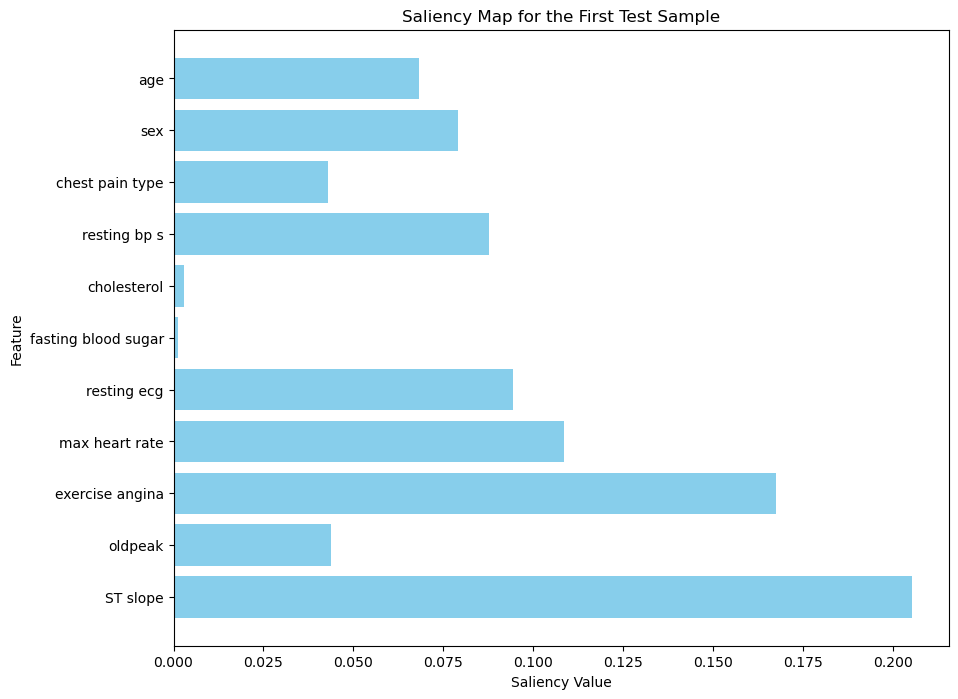

In [13]:
import torch
import matplotlib.pyplot as plt

def saliency_map(model, X_sample, y_sample):
    # Assicurati che il modello sia in modalità valutazione
    model.eval()
    
    # Richiede il gradiente per l'input
    X_sample.requires_grad_()
    
    # Passa il campione attraverso il modello
    output = model(X_sample)
    
    # Seleziona l'output corrispondente alla classe predetta
    output_idx = output.argmax(dim=1).item()
    output_max = output[0, output_idx]
    
    # Calcola il gradiente rispetto all'input
    output_max.backward()
    
    # Ottieni la mappa di salienza
    saliency = X_sample.grad.abs().squeeze().detach().cpu().numpy()
    
    return saliency

# Seleziona un campione di test
X_sample = X_test_tensor[0:1]  # Prendi il primo campione dal test set
y_sample = y_test_tensor[0:1]  # Prendi la corrispondente etichetta

# Calcola la mappa di salienza
saliency = saliency_map(loaded_model, X_sample, y_sample)

# Nomi delle feature (sostituisci con i nomi effettivi delle tue feature)
feature_names = df.columns[:-1]  # Presupponendo che l'ultima colonna sia la target

# Visualizza la mappa di salienza in un grafico orizzontale
plt.figure(figsize=(10, 8))
plt.barh(range(len(saliency)), saliency, color='skyblue')
plt.yticks(ticks=range(len(saliency)), labels=feature_names)
plt.xlabel('Saliency Value')
plt.ylabel('Feature')
plt.title('Saliency Map for the First Test Sample')
plt.gca().invert_yaxis()  # Inverte l'asse y per avere la feature più importante in alto
plt.show()



#######################################################################################################################################################
#######################################################################################################################################################
#######################################################################################################################################################

####################################################################################################################################################### 
####################################################################################################################################################### 
#######################################################################################################################################################

#######################################################################################################################################################
#######################################################################################################################################################
#######################################################################################################################################################

####################################################################################################################################################### 
#######################################################################################################################################################
#######################################################################################################################################################

#######################################################################################################################################################
####################################################################################################################################################### 
#######################################################################################################################################################

In [ ]:
import torch
import numpy as np
import random

# Imposta il seed per garantire la riproducibilità
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Se stai usando una GPU, puoi impostare anche questo:
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # se usi più GPU

# Assicurati che il determinismo sia attivo (potrebbe rallentare un po' l'esecuzione)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

##########################################################################################################################
# Definizione della classe MLP con possibilità di variare la funzione di attivazione
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(activation_fn())
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Funzione per addestrare e valutare il modello
def train_and_evaluate_model(hidden_sizes, activation_fn):
    model = MLP(input_size=X_train.shape[1], hidden_sizes=hidden_sizes, output_size=len(np.unique(y)), activation_fn=activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_accuracy = accuracy_score(y_test_tensor, test_predicted)
    
    return test_accuracy

# Strutture da testare
hidden_layer_structures = [
    [5], [6], [7], [8], [10], [12], [15], [18], [20], [25], [30],
    [5,5], 
    [6,5], [6,6],
    [7,5], [7,6], [7,7],
    [8,5], [8,6], [8,7], [8,8],
    [10,5], [10,6], [10,7], [10,8], [10,10],
    [12,5], [12,6], [12,7], [12,8], [12,10], [12,12],
    [15,5], [15,6], [15,7], [15,8], [15,10], [15,12], [15,15],
    [20,5], [20,6], [20,7], [20,8], [20,10], [20,12], [20,15], [20,20],
    [32],
    [64],
    [32, 16],
    [64, 32],
]

# Funzioni di attivazione da testare
activation_functions = [
    nn.ReLU,
    nn.Sigmoid,
    nn.Tanh,
    nn.LeakyReLU,
    nn.ELU,
    nn.SELU,
    nn.Softplus,
    nn.Softsign,
    nn.ReLU6,
    nn.GELU,
    nn.Hardtanh,
    nn.LogSigmoid,
    
]

# Testare diverse strutture e funzioni di attivazione
results = {}
for structure in hidden_layer_structures:
    for activation_fn in activation_functions:
        accuracy = train_and_evaluate_model(structure, activation_fn)
        config_name = f"Structure: {structure}, Activation: {activation_fn.__name__}"
        results[config_name] = accuracy
        print(f"{config_name} -> Test Accuracy = {accuracy:.4f}")



Structure: [5], Activation: ReLU -> Test Accuracy = 0.7017
Structure: [5], Activation: Sigmoid -> Test Accuracy = 0.4706
Structure: [5], Activation: Tanh -> Test Accuracy = 0.7017
Structure: [5], Activation: LeakyReLU -> Test Accuracy = 0.6639
Structure: [5], Activation: ELU -> Test Accuracy = 0.6933
Structure: [5], Activation: SELU -> Test Accuracy = 0.5756
Structure: [5], Activation: Softplus -> Test Accuracy = 0.7689
Structure: [5], Activation: Softsign -> Test Accuracy = 0.5462
Structure: [5], Activation: ReLU6 -> Test Accuracy = 0.7563
Structure: [5], Activation: GELU -> Test Accuracy = 0.7101
Structure: [5], Activation: Hardtanh -> Test Accuracy = 0.6765
Structure: [5], Activation: LogSigmoid -> Test Accuracy = 0.5252
Structure: [6], Activation: ReLU -> Test Accuracy = 0.5924
Structure: [6], Activation: Sigmoid -> Test Accuracy = 0.7311
Structure: [6], Activation: Tanh -> Test Accuracy = 0.7395
Structure: [6], Activation: LeakyReLU -> Test Accuracy = 0.8025
Structure: [6], Activa

In [5]:
# Mostra i risultati
best_config = max(results, key=results.get)
print(f"Best Configuration: {best_config} with Test Accuracy = {results[best_config]:.4f}")

Best Configuration: Structure: [20, 12], Activation: SELU with Test Accuracy = 0.8571


Accuracy: 0.5630
Precision: 0.8056
Recall: 0.2302
F1-Score: 0.3580
ROC-AUC: 0.7327
Log-Loss: 0.6722

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.94      0.67       112
           1       0.81      0.23      0.36       126

    accuracy                           0.56       238
   macro avg       0.66      0.58      0.51       238
weighted avg       0.67      0.56      0.50       238


Confusion Matrix:
[[105   7]
 [ 97  29]]


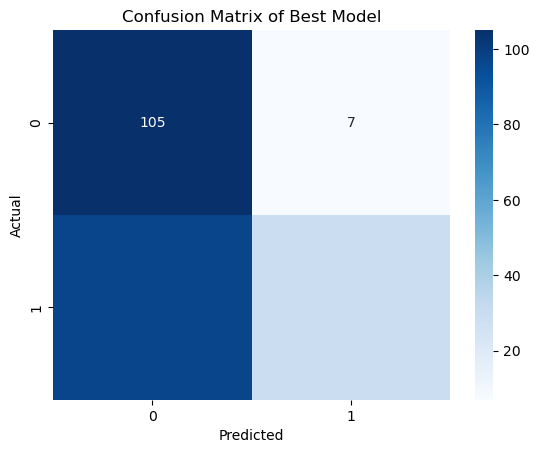

In [6]:
import torch
import numpy as np
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Imposta il seed per garantire la riproducibilità
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Se stai usando una GPU, puoi impostare anche questo:
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # se usi più GPU

# Assicurati che il determinismo sia attivo (potrebbe rallentare un po' l'esecuzione)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

############################################################################################################################################
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ricrea il modello migliore con la configurazione trovata
best_structure = [8]  # Usa la struttura trovata
best_activation_fn = nn.ReLU6   # Usa la funzione di attivazione trovata

# Crea il modello migliore
best_model = MLP(input_size=X_train.shape[1], hidden_sizes=best_structure, output_size=len(np.unique(y)), activation_fn=best_activation_fn)

# Se hai salvato lo stato del modello, puoi ricaricarlo qui (opzionale)
# best_model.load_state_dict(torch.load('best_model.pth'))

# Addestra di nuovo il modello con la configurazione migliore se non hai già salvato il modello
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    best_model.train()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Valuta il modello e crea la matrice di confusione
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs.data, 1)

# Converte i tensori PyTorch in array numpy per calcolare le metriche
y_true = y_test_tensor.numpy()
y_pred = test_predicted.numpy()
y_prob = torch.softmax(test_outputs, dim=1).numpy()[:, 1]  # Probabilità della classe positiva

# Calcola le metriche
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
logloss = log_loss(y_true, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Log-Loss: {logloss:.4f}")

# Report di classificazione completo
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Matrice di confusione
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualizza la matrice di confusione
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Best Model')
plt.show()


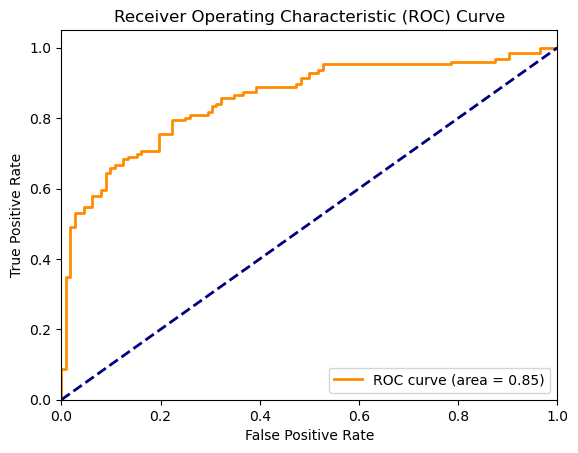

In [93]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Supponiamo che 'best_model' sia il modello migliore che hai identificato
# Esegui le predizioni in termini di probabilità per il calcolo della ROC curve
best_model.eval()
with torch.no_grad():
    test_probabilities = best_model(X_test_tensor)
    test_probabilities = torch.softmax(test_probabilities, dim=1)  # Softmax per ottenere probabilità
    test_probabilities = test_probabilities[:, 1].numpy()  # Probabilità per la classe 1

# Calcola ROC curve e AUC
fpr, tpr, thresholds = roc_curve(y_test_tensor.numpy(), test_probabilities)
roc_auc = auc(fpr, tpr)

# Plot della ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [27]:
# pip install networkx matplotlib

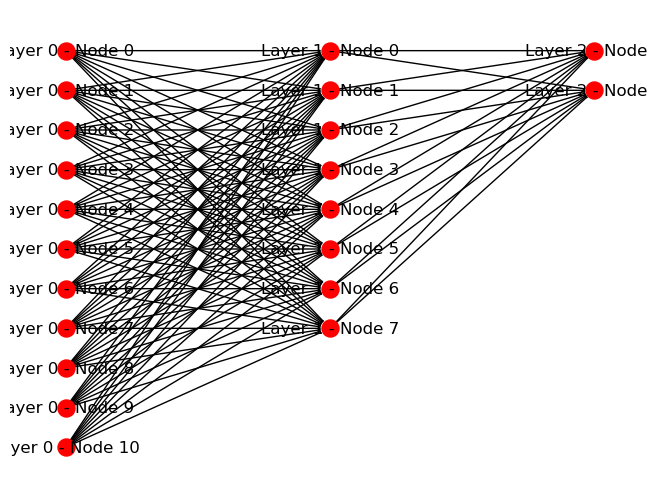

In [78]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_neural_network(layer_sizes):
    G = nx.DiGraph()

    # Aggiungi i nodi dei layer
    for i, layer_size in enumerate(layer_sizes):
        for j in range(layer_size):
            G.add_node(f'Layer {i} - Node {j}', pos=(i, -j))

    # Aggiungi le connessioni tra i nodi
    for i in range(len(layer_sizes) - 1):
        for j in range(layer_sizes[i]):
            for k in range(layer_sizes[i + 1]):
                G.add_edge(f'Layer {i} - Node {j}', f'Layer {i + 1} - Node {k}')

    # Disegna il grafo
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=True, node_size=150, node_color='red', arrowsize=1)
    plt.show()

# Definisci le dimensioni dei layer della rete
layer_sizes = [X_train.shape[1], 8, len(np.unique(y))]  # Input, hidden1, hidden2, hidden3, output
draw_neural_network(layer_sizes)


INTERPRETAZIONE MEDIANTE : Permutazione dell'Importanza delle Feature

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

def permutation_importance(model, X_test, y_test):
    baseline_accuracy = accuracy_score(y_test, model(X_test).argmax(dim=1).numpy())
    importances = []

    for col in range(X_test.shape[1]):
        X_test_permuted = X_test.clone()
        X_test_permuted[:, col] = shuffle(X_test_permuted[:, col])
        permuted_accuracy = accuracy_score(y_test, model(X_test_permuted).argmax(dim=1).numpy())
        importances.append(baseline_accuracy - permuted_accuracy)

    return importances


In [80]:
# Calcola l'importanza delle feature
feature_importances = permutation_importance(best_model, X_test_tensor, y_test_tensor)

# Ordina le feature per importanza
sorted_idx = np.argsort(feature_importances)[::-1]

# Stampa i nomi delle feature insieme ai valori di importanza
print("Feature Importance (Permutation):")
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")


Feature Importance (Permutation):
exercise angina: 0.0378
oldpeak: 0.0336
ST slope: 0.0252
max heart rate: 0.0252
chest pain type: 0.0168
resting bp s: 0.0126
sex: 0.0126
fasting blood sugar: 0.0000
cholesterol: -0.0084
age: -0.0126
resting ecg: -0.0168


INTERPRETAZIONE MEDIANTE : Mappe di Salienza (Saliency Maps)

In [81]:
import torch

def saliency_map(best_model, X_sample):
    X_sample = X_sample.requires_grad_(True)
    output = best_model(X_sample)
    output_idx = output.argmax()
    output_max = output[0, output_idx]
    output_max.backward()

    saliency = X_sample.grad.abs().numpy()
    return saliency

# Calcola la mappa di salienza per un campione specifico
X_sample = X_test_tensor[0:1]  # Prendi un singolo campione di test
saliency = saliency_map(best_model, X_sample)

print("Saliency Map for the first sample:")
print(saliency)


Saliency Map for the first sample:
[[0.14531055 0.01130582 0.00974822 0.05383965 0.04894461 0.02377637
  0.10051993 0.07272755 0.01914997 0.12434854 0.00801532]]


In [82]:
feature_names = df.columns[:-1]  # Presupponendo che l'ultima colonna sia il target

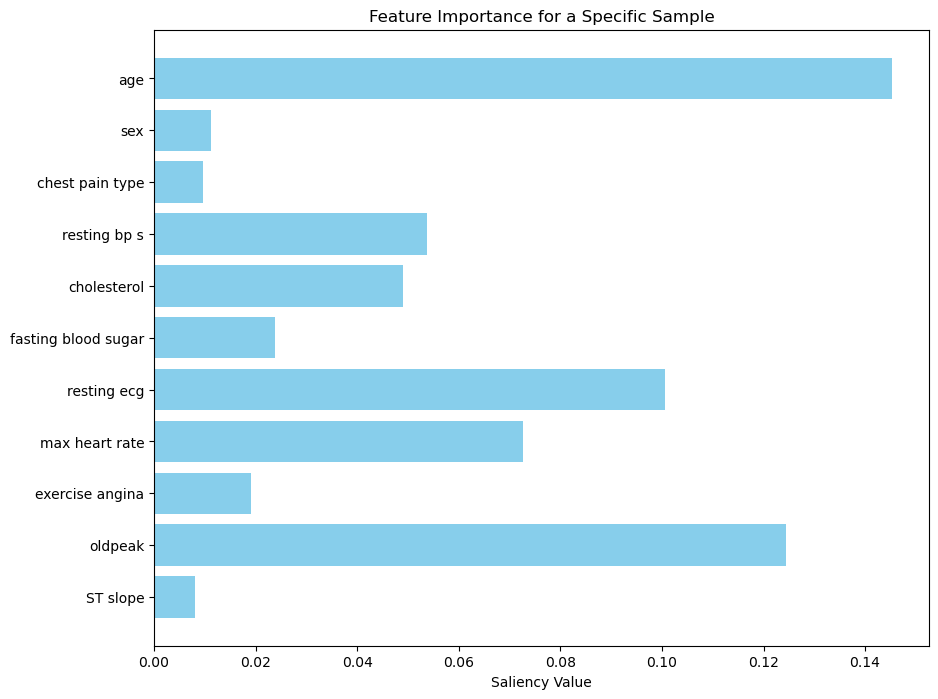

In [83]:
import matplotlib.pyplot as plt

def plot_saliency_map(saliency, feature_names):
    saliency_values = saliency[0]
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, saliency_values, color="skyblue")
    plt.xlabel("Saliency Value")
    plt.title("Feature Importance for a Specific Sample")
    plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
    plt.show()

# Supponiamo che 'saliency' sia la mappa di salienza ottenuta
# e 'feature_names' sia la lista dei nomi delle feature
plot_saliency_map(saliency, feature_names)


## 🔹 KAN Implementation

In [6]:
df.isnull().sum()

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

In [7]:
import pandas as pd

df['sex'] = df['sex'].astype('object')
df['chest pain type'] = df['chest pain type'].astype('object')
df['fasting blood sugar'] = df['fasting blood sugar'].astype('object')
df['resting ecg'] = df['resting ecg'].astype('object')
df['target'] = df['target'].astype('object')
df['exercise angina'] = df['exercise angina'].astype('object')
df['ST slope'] = df['ST slope'].astype('object')


# Verifica la conversione
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   object 
 2   chest pain type      1190 non-null   object 
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   object 
 6   resting ecg          1190 non-null   object 
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   object 
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   object 
 11  target               1190 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 111.7+ KB
None


In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Label encode categorical features
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Separate features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

In [9]:
# Fill missing values in numerical features with the mean value
numerical_features = X.select_dtypes(include=['number']).columns

# X[numerical_features] = X[numerical_features].fillna(X[numerical_features].mean())

In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Standardize numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Stratify the split to ensure balanced classes in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
import torch

# Convert data to tensors
dataset = {
    'train_input': torch.tensor(X_train.values.astype('float32')),
    'test_input': torch.tensor(X_test.values.astype('float32')),
    'train_label': torch.tensor(y_train.values.astype('float32')).view(-1, 1),
    'test_label': torch.tensor(y_test.values.astype('float32')).view(-1, 1)
}

In [12]:
# Mostra i tensori per verificare
dataset['train_input'], dataset['train_label']

(tensor([[-0.0770,  0.5560, -0.2489,  ..., -0.7952, -0.8498,  0.6156],
         [-1.3598,  0.5560, -1.3184,  ..., -0.7952, -0.8498,  0.6156],
         [-0.1839, -1.7986,  0.8205,  ...,  1.2575,  0.5316,  0.6156],
         ...,
         [-1.0391,  0.5560, -1.3184,  ..., -0.7952, -0.8498, -1.0232],
         [-0.1839,  0.5560, -1.3184,  ..., -0.7952, -0.8498, -1.0232],
         [-1.0391,  0.5560,  0.8205,  ..., -0.7952, -0.8498, -1.0232]]),
 tensor([[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
   

In [13]:
y.value_counts()

target
1    629
0    561
Name: count, dtype: int64

In [14]:
# Confirm the shapes of tensors
print(dataset['train_input'].shape, dataset['train_label'].shape)
print(dataset['test_input'].shape, dataset['test_label'].shape)

torch.Size([952, 11]) torch.Size([952, 1])
torch.Size([238, 11]) torch.Size([238, 1])


In [15]:
# Model training setup (example using KAN library)
from kan import KAN

model = KAN(width=[X_train.shape[1], 8, 2], grid=3, k=3)

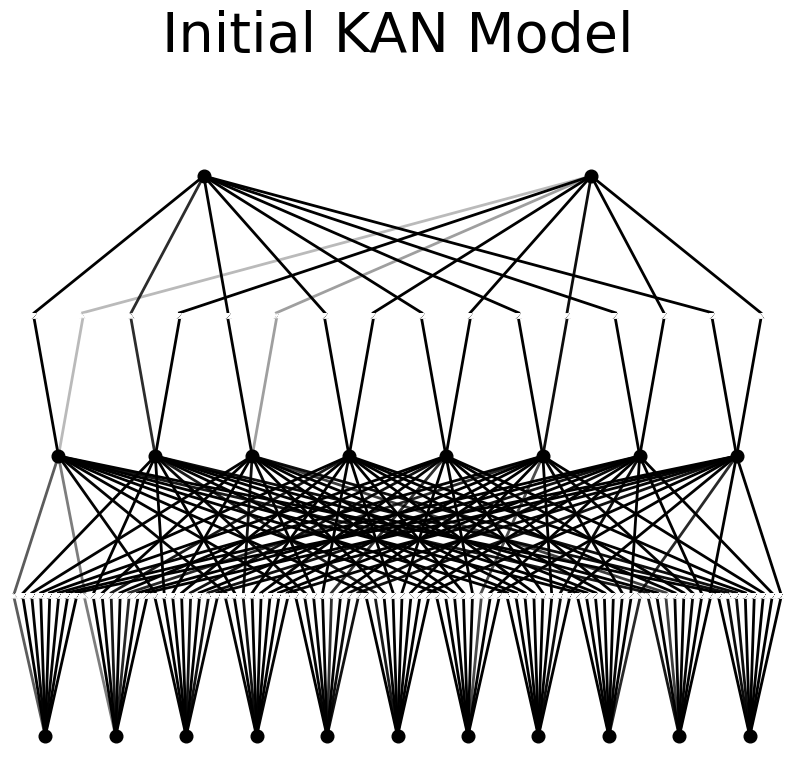

In [16]:
# Initial plot of the model
model(dataset['train_input'])  # Perform a forward pass to initialize
model.plot(beta=100, scale=1, title='Initial KAN Model')  # Adjust beta and scale as needed

train loss: 2.53e-01 | test loss: 3.25e-01 | reg: 2.59e+01 : 100%|████| 5/5 [00:48<00:00,  9.70s/it]


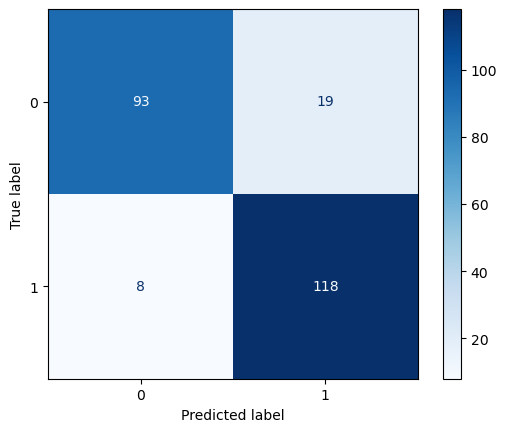

Train Accuracy: 0.9317
Test Accuracy: 0.8866


In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from kan import KAN
import matplotlib.pyplot as plt


# Funzioni per calcolare l'accuratezza sul train e sul test set
def train_acc():
    with torch.no_grad():
        return torch.mean((torch.round(model(dataset['train_input'])[:, 0]) == dataset['train_label'][:, 0]).float())

def test_acc():
    with torch.no_grad():
        return torch.mean((torch.round(model(dataset['test_input'])[:, 0]) == dataset['test_label'][:, 0]).float())


# Cartella in cui salvare i risultati (assicurati che la cartella esista)
image_folder = r'C:\Users\Luca Ruocco\Desktop\Dataset Tesi Luca\1. HEART\video_heart'

# Addestramento del modello utilizzando l'ottimizzatore LBFGS
results = model.train(
    dataset, 
    opt="LBFGS", 
    steps=5, 
    metrics=(train_acc, test_acc), 
    save_fig=True, 
    beta=7, 
    img_folder=image_folder
)

# Predizioni sul set di test
with torch.no_grad():
    test_preds = torch.round(model(dataset['test_input'])[:, 0])

# Converti i tensori in numpy array per scikit-learn
y_test_np = dataset['test_label'].numpy()
test_preds_np = test_preds.numpy()

# Costruisci la matrice di confusione
cm = confusion_matrix(y_test_np, test_preds_np)

# Visualizza la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Stampa l'accuratezza finale su train e test
print(f"Train Accuracy: {results['train_acc'][-1]:.4f}")
print(f"Test Accuracy: {results['test_acc'][-1]:.4f}")

In [ ]:

################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################

In [18]:
import os
import numpy as np
import moviepy.video.io.ImageSequenceClip

image_folder = r'C:\Users\Luca Ruocco\Desktop\Dataset Tesi Luca\1. HEART\video_heart'
video_name = 'video_classification'
fps = 1

files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)
image_files = [f"{image_folder}/{str(idx)}.jpg" for idx in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(f"{video_name}.mp4")

Moviepy - Building video video_classification.mp4.
Moviepy - Writing video video_classification.mp4



Moviepy - Done !
Moviepy - video ready video_classification.mp4


In [ ]:
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################

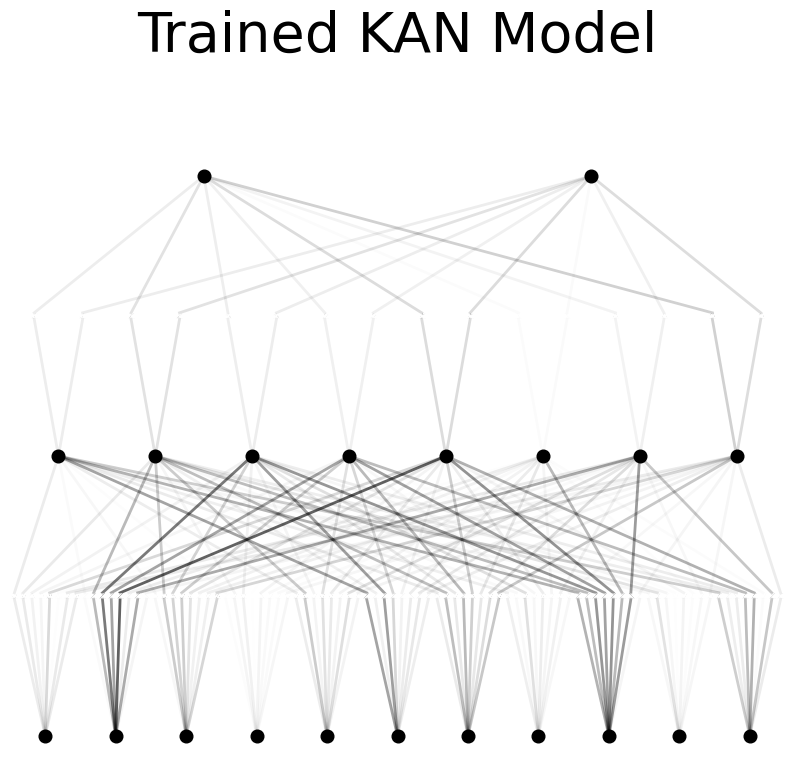

In [18]:
# Plot the model after training
model.plot(beta=2, scale=1, title='Trained KAN Model')

In [19]:
#FIX SPLINE UTILIZZATE (FUNZIONI ATTIVAZIONE)

lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.960649311542511
fixing (0,0,1) with sin, r2=0.9994602203369141
fixing (0,0,2) with sin, r2=0.9927770495414734
fixing (0,0,3) with tanh, r2=0.8151295781135559
fixing (0,0,4) with sin, r2=0.9932719469070435
fixing (0,0,5) with sin, r2=0.9923287034034729
fixing (0,0,6) with sin, r2=0.9971547722816467
fixing (0,0,7) with sin, r2=0.988368034362793
fixing (0,1,0) with x^4, r2=1.000001072883606
fixing (0,1,1) with abs, r2=1.0000008344650269
fixing (0,1,2) with tan, r2=1.0000008344650269
fixing (0,1,3) with log, r2=1.0000009536743164
fixing (0,1,4) with exp, r2=1.0000009536743164
fixing (0,1,5) with x^4, r2=1.0000009536743164
fixing (0,1,6) with abs, r2=1.0000008344650269
fixing (0,1,7) with tan, r2=1.0000008344650269
fixing (0,2,0) with tanh, r2=0.9999415278434753
fixing (0,2,1) with tan, r2=1.000000238418579
fixing (0,2,2) with tan, r2=1.000000238418579
fixing (0,2,3) with tan, r2=1.0000004768371582
fixing (0,2,4) with sin, r2=1.0000003576278687
fixing (0,2,5) w

In [20]:
formula1,formula2 = model.symbolic_formula()[0]

In [21]:
formula1

1.83*sin(0.21*(1 - 0.18*x_11)**3 + 0.08*(1 - 0.46*x_6)**4 - 0.16*sin(1.39*x_1 + 3.78) + 0.16*sin(0.8*x_10 - 8.58) + 0.16*sin(0.6*x_4 - 5.18) - 0.08*sin(1.05*x_8 - 6.37) + 0.12*tan(1.57*x_3 - 0.42) - 0.09*tanh(3.0*x_5 + 2.98) - 0.05*Abs(8.7*x_7 + 0.03) + 7.74) + 0.2*sin(0.2*(0.17 - x_7)**2 - 0.e-2*(-0.63*x_2 - 1)**4 - 0.02*exp(3.0*x_9) + 2.0*sin(0.4*x_1 + 8.0) + 0.3*sin(0.38*x_4 - 9.8) - 1.33*sin(0.59*x_5 + 4.99) - 0.4*tan(9.92*x_6 + 0.8) + 0.23*tan(0.41*x_8 - 6.18) + 0.75*tanh(0.31*x_10 - 0.49) + 0.06*tanh(10.0*x_3 + 2.06) - 6.65 + 0.96*exp(-0.64*x_11)) - 0.16*sin(-1.06*(0.47 - x_9)**4 + 0.4*(1 - 0.25*x_11)**4 + 0.71*(-0.7*x_8 - 1)**2 - 0.63*sin(1.09*x_1 - 0.72) - 1.14*sin(0.4*x_10 - 9.79) + 0.97*sin(0.72*x_4 - 8.03) - 4.06*sin(0.35*x_5 + 1.78) + 0.08*tan(2.01*x_3) - 3.67*tan(9.12*x_2 + 4.76) + 2.72*Abs(1.61*x_6 - 0.51) + 0.09*Abs(8.75*x_7 + 1.02) + 1.1) - 0.08*sin(-0.03*(1 - 0.39*x_2)**4 + 0.02*(-x_11 - 0.05)**4 + 0.22*(-0.68*x_5 - 1)**2 - 0.11*log(4.65*x_6 + 2.58) + 0.05*sin(1.41*x_1

In [22]:
formula2

1.57*sin(0.23*(1 - 0.18*x_11)**3 + 0.08*(1 - 0.46*x_6)**4 - 0.17*sin(1.39*x_1 + 3.78) + 0.17*sin(0.8*x_10 - 8.58) + 0.17*sin(0.6*x_4 - 5.18) - 0.09*sin(1.05*x_8 - 6.37) + 0.13*tan(1.57*x_3 - 0.42) - 0.1*tanh(3.0*x_5 + 2.98) - 0.05*Abs(8.7*x_7 + 0.03) - 4.83) + 0.2*sin(0.2*(0.17 - x_7)**2 - 0.e-2*(-0.63*x_2 - 1)**4 - 0.02*exp(3.0*x_9) + 1.97*sin(0.4*x_1 + 8.0) + 0.3*sin(0.38*x_4 - 9.8) - 1.31*sin(0.59*x_5 + 4.99) - 0.4*tan(9.92*x_6 + 0.8) + 0.22*tan(0.41*x_8 - 6.18) + 0.73*tanh(0.31*x_10 - 0.49) + 0.06*tanh(10.0*x_3 + 2.06) - 6.57 + 0.95*exp(-0.64*x_11)) + 0.16*sin(-1.06*(0.47 - x_9)**4 + 0.4*(1 - 0.25*x_11)**4 + 0.7*(-0.7*x_8 - 1)**2 - 0.62*sin(1.09*x_1 - 0.72) - 1.13*sin(0.4*x_10 - 9.79) + 0.96*sin(0.72*x_4 - 8.03) - 4.04*sin(0.35*x_5 + 1.78) + 0.08*tan(2.01*x_3) - 3.65*tan(9.12*x_2 + 4.76) + 2.7*Abs(1.61*x_6 - 0.51) + 0.09*Abs(8.75*x_7 + 1.02) + 4.24) + 0.18*sin(0.34*(-0.54*x_6 - 1)**2 + 0.77*(-0.39*x_7 - 1)**2 + 0.14*(-x_8 - 0.58)**2 + 0.56*(-x_9 - 0.08)**4 - 0.56*log(6.09 - 8.18*x_

In [23]:
# Function to calculate accuracy of symbolic formula
import sympy as sp

def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    # Convert your formula to a function that can accept NumPy arrays
    formula_func = sp.lambdify([sp.symbols(f'x_{i+1}') for i in range(X.shape[1])], formula, "numpy")
    for i in range(batch):
        prediction = formula_func(*X[i])  # Calculate the formula result
        correct += (np.round(prediction) == y[i])
    return correct / batch

# Calculate accuracy of the formula1 on training and testing data
train_accuracy = acc(formula1, dataset['train_input'].numpy(), dataset['train_label'].numpy())
test_accuracy = acc(formula1, dataset['test_input'].numpy(), dataset['test_label'].numpy())

# Calculate accuracy of the formula2 on training and testing data
train_accuracy2 = acc(formula2, dataset['train_input'].numpy(), dataset['train_label'].numpy())
test_accuracy2 = acc(formula2, dataset['test_input'].numpy(), dataset['test_label'].numpy())

<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in log
  return 1.83*sin(0.21*(1 - 0.18*x_11)**3 + 0.08*(1 - 0.46*x_6)**4 - 0.16*sin(1.39*x_1 + 3.78) + 0.16*sin(0.8*x_10 - 8.58) + 0.16*sin(0.6*x_4 - 5.18) - 0.08*sin(1.05*x_8 - 6.37) + 0.12*tan(1.57*x_3 - 0.42) - 0.09*tanh(3.0*x_5 + 2.98) - 0.05*abs(8.7*x_7 + 0.03) + 7.74) + 0.2*sin(0.2*(0.17 - x_7)**2 - 0.e-2*(-0.63*x_2 - 1)**4 - 0.02*exp(3.0*x_9) + 2.0*sin(0.4*x_1 + 8.0) + 0.3*sin(0.38*x_4 - 9.8) - 1.33*sin(0.59*x_5 + 4.99) - 0.4*tan(9.92*x_6 + 0.8) + 0.23*tan(0.41*x_8 - 6.18) + 0.75*tanh(0.31*x_10 - 0.49) + 0.06*tanh(10.0*x_3 + 2.06) - 6.65 + 0.96*exp(-0.64*x_11)) - 0.16*sin(-1.06*(0.47 - x_9)**4 + 0.4*(1 - 0.25*x_11)**4 + 0.71*(-0.7*x_8 - 1)**2 - 0.63*sin(1.09*x_1 - 0.72) - 1.14*sin(0.4*x_10 - 9.79) + 0.97*sin(0.72*x_4 - 8.03) - 4.06*sin(0.35*x_5 + 1.78) + 0.08*tan(2.01*x_3) - 3.67*tan(9.12*x_2 + 4.76) + 2.72*abs(1.61*x_6 - 0.51) + 0.09*abs(8.75*x_7 + 1.02) + 1.1) - 0.08*sin(-0.03*(1 - 0.39*x_2)**4 + 0.02*(-x_11 -

In [24]:
print('Train accuracy of the formula 1: ', train_accuracy)
print( 'Test accuracy of the formula 1:', test_accuracy)

Train accuracy of the formula 1:  [0.88970588]
Test accuracy of the formula 1: [0.85294118]


In [25]:
print('Train accuracy of the formula 2: ', train_accuracy2)
print( 'Test accuracy of the formula 2:', test_accuracy2)

Train accuracy of the formula 2:  [0.89390756]
Test accuracy of the formula 2: [0.85294118]


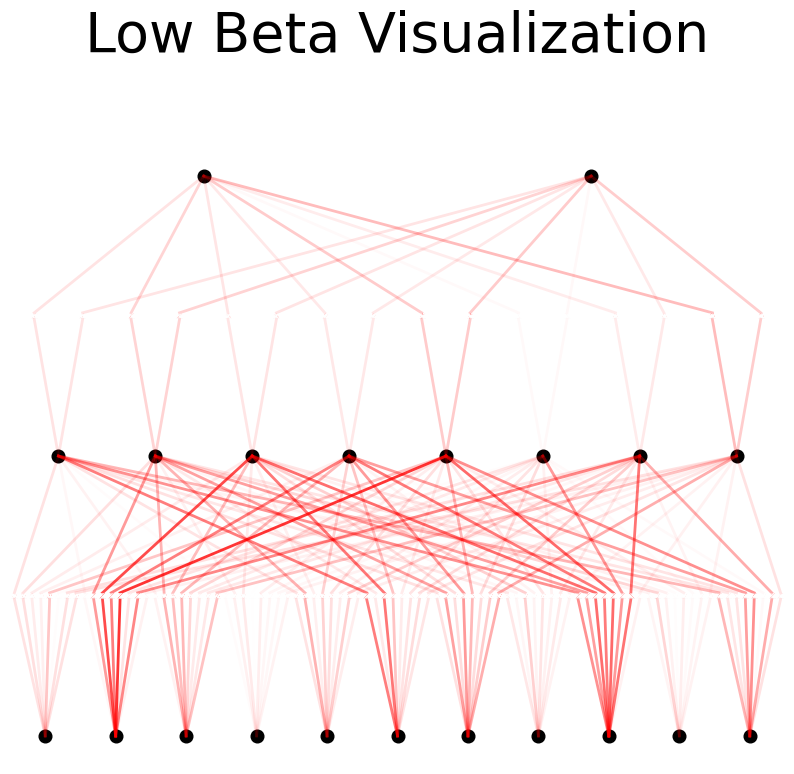

In [26]:
model.plot(beta=3, scale=1, title='Low Beta Visualization')

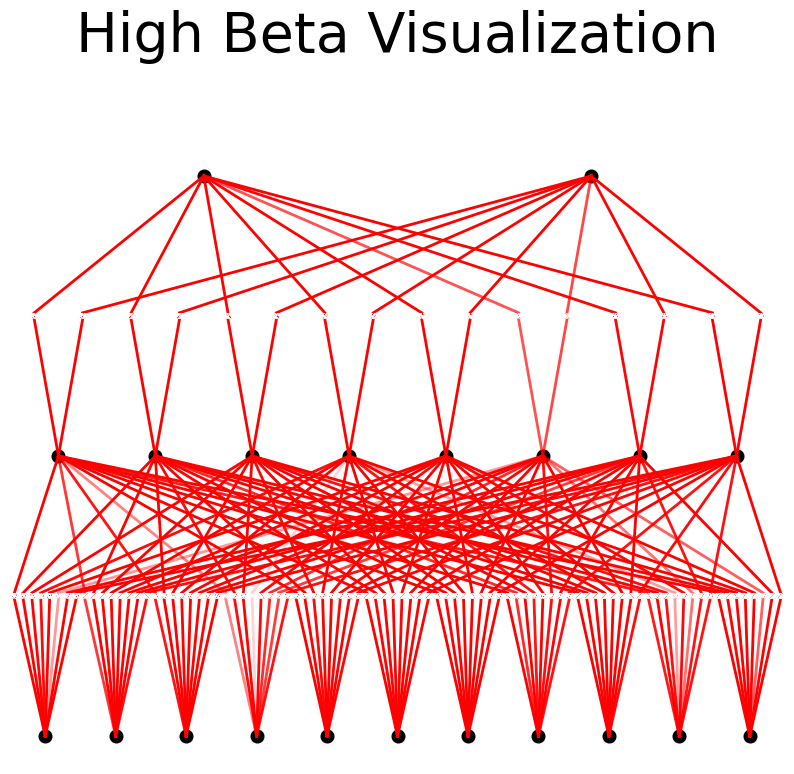

In [27]:
model.plot(beta=100, scale=1, title='High Beta Visualization')

In [ ]:
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################

In [ ]:
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################

In [ ]:
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################

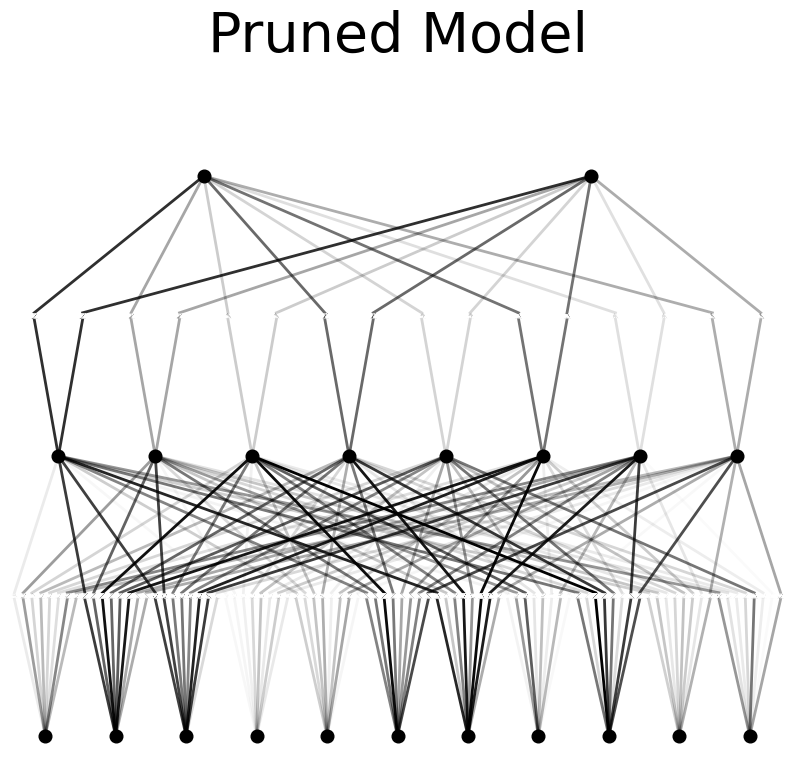

In [39]:
model2 = model.prune(threshold=1e-4)
model2(dataset['train_input'])
model2.plot(scale=1, beta=10,title='Pruned Model')

In [41]:
################################################################################################################################################################################################################
################################################################################################################################################################################################################
################################################################################################################################################################################################################
################################################################################################################################################################################################################
################################################################################################################################################################################################################

In [36]:
import numpy as np
import torch

# Definisci i parametri della griglia
grids = np.array([5, 10, 20, 50, 100])
train_losses = []
test_losses = []
steps = 50
k = 3

# Funzioni per calcolare l'accuratezza di addestramento e di test
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

# Ciclo per addestrare il modello con diverse griglie
for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[X_train.shape[1], 8, 2], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[X_train.shape[1], 8, 2], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    
    # Addestramento del modello
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30, metrics=(train_acc, test_acc))
    
    # Registra le perdite di addestramento e di test
    train_losses += results['train_loss']
    test_losses += results['test_loss']


train loss: 1.68e-01 | test loss: 3.76e-01 | reg: 2.68e+01 : 100%|██| 50/50 [01:41<00:00,  2.04s/it]
train loss: 1.02e-01 | test loss: 5.27e-01 | reg: 2.61e+01 : 100%|██| 50/50 [01:56<00:00,  2.33s/it]
train loss: 2.72e-02 | test loss: 4.56e-01 | reg: 2.55e+01 : 100%|██| 50/50 [02:15<00:00,  2.71s/it]
train loss: 1.17e-03 | test loss: 3.56e-01 | reg: 2.40e+01 : 100%|██| 50/50 [03:25<00:00,  4.10s/it]
train loss: 5.82e-04 | test loss: 3.71e-01 | reg: 2.41e+01 : 100%|██| 50/50 [04:54<00:00,  5.89s/it]


In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

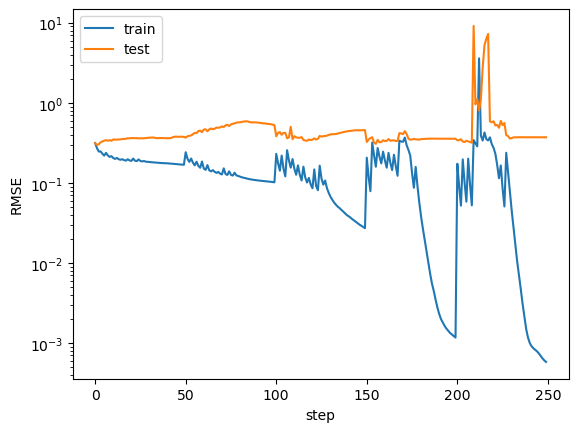

In [37]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Text(0, 0.5, 'RMSE')

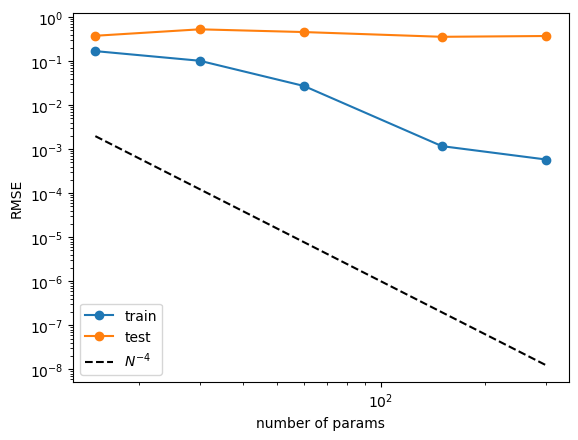

In [38]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')

In [45]:
import numpy as np
from sklearn.metrics import accuracy_score

def calculate_feature_importance(model, X_test, y_test, feature_names):
    # Predizioni di base sul set di test
    baseline_preds = torch.round(model(X_test)[:, 0])
    baseline_acc = accuracy_score(y_test, baseline_preds.detach().numpy())
    
    feature_importances = {}
    
    # Calcola l'importanza di ogni feature
    for i in range(X_test.shape[1]):
        X_permuted = X_test.clone()
        X_permuted[:, i] = X_permuted[:, i][torch.randperm(X_permuted.size(0))]  # Permuta i valori della feature
        
        # Predizioni dopo la permutazione
        permuted_preds = torch.round(model(X_permuted)[:, 0])
        permuted_acc = accuracy_score(y_test, permuted_preds.detach().numpy())
        
        # L'importanza della feature è data dalla differenza nell'accuratezza
        importance = baseline_acc - permuted_acc
        feature_importances[feature_names[i]] = importance
    
    # Ordina le feature in base all'importanza
    sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_importances

# Definisci i nomi delle feature (modifica questa lista in base alle tue variabili)
feature_names = ['Feature_0','Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5','Feature_6','Feature_7','Feature_8','Feature_9','Feature_10']

# Esegui la funzione per ottenere l'importanza delle feature
importances = calculate_feature_importance(model, dataset['test_input'], dataset['test_label'], feature_names)

# Stampa le feature ordinate con i loro nomi
for feature, importance in importances:
    print(f'{feature}: {importance:.4f}')


Feature_2: 0.1303
Feature_4: 0.1218
Feature_10: 0.1218
Feature_3: 0.0882
Feature_6: 0.0714
Feature_9: 0.0714
Feature_7: 0.0672
Feature_0: 0.0630
Feature_1: 0.0588
Feature_8: 0.0588
Feature_5: 0.0504


## 📊 Results & Conclusion

- **MLP** provides a strong baseline for classification on the Heart Disease dataset.  
- **KAN** achieves **superior accuracy and robustness**, while also offering interpretability through symbolic function representation.  

👉 In line with the thesis results, KAN can be considered a **valid and often superior alternative** to MLPs in tasks where accuracy and explainability are critical.
